# Machine Learning - Project

In [21]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
import yfinance as yf

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seanc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# pip install matplotlib wordcloud nltk pandas

## 1. Data Preparation

In [23]:
pd.options.display.max_columns = None

df = pd.read_csv('reddit_wsb.csv')

In [24]:
df.shape

(53187, 8)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      53187 non-null  object 
 1   score      53187 non-null  int64  
 2   id         53187 non-null  object 
 3   url        53187 non-null  object 
 4   comms_num  53187 non-null  int64  
 5   created    53187 non-null  float64
 6   body       24738 non-null  object 
 7   timestamp  53187 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.2+ MB


In [26]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


## 2. Data Exploration

### Feature explanations

> - Title: The title of the Reddit post.
> - Score: The Reddit score associated with the post, indicating the number of upvotes minus the number of downvotes (post's popularity).
> - Id: The unique identifier for each post.
> - Url: The URL of the post.
> - Comms_num: The number of comments on the post (engagement).
> - Created: The timestamp, expressed in epoch time format, of when the post was created.
> - Body: The text content of the post.
> - Timestamp: The timestamp of when the post was created.

In [27]:
df_explore = df.copy()
df_explore.set_index('timestamp', inplace=True)
df_explore = df_explore[['title', 'score', 'comms_num', 'body', 'id']]

In [28]:
df_explore.sample(5, random_state=0)

,title,score,comms_num,body,id
timestamp,,,,,
2021-02-03 03:18:10,'This is real' — Mark Cuban says Reddit trader...,6938,235,NaN,lb0yc1
2021-03-22 11:34:22,"You’re buying based on gut feeling, selling on...",4985,536,**Not a trading advise.**\n\nHey there folks a...,mabmyk
2021-04-14 01:55:40,"Anyone remember my 4/23C at 4,200? 5/7C and al...",33,10,NaN,mq3x2f
2021-02-04 14:03:33,Losing more and more . Picture is how i feel b...,58,22,NaN,lc70wr
2021-03-18 02:56:09,"$TR Tootsie Roll, $AMC and stimmi. Throw in a ...",45,23,NaN,m74wxe


In [29]:
# To understand how big the file is and how many variables it has
print('This dataframe has' ,df_explore.shape[0], 'rows and', df_explore.shape[1], 'columns')

This dataframe has 53187 rows and 5 columns


In [30]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53187 entries, 2021-01-28 21:37:41 to 2021-08-02 12:00:14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      53187 non-null  object
 1   score      53187 non-null  int64 
 2   comms_num  53187 non-null  int64 
 3   body       24738 non-null  object
 4   id         53187 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


- We can see that more of 50% of the 'body' feature are NULL
- Dates range are from January 28th, 2021 to August 2nd, 2021. Seven months of data.

**`Feature title`**
> Let's see what words/stocks are the most common 


In [31]:
# Function to visualize the word cloud and word frequency for a given feature

def word_cloud(text_feature):
    titles = text_feature

    # Combining all titles into a single string
    all_titles = ' '.join(titles)

    # Tokenizing the text (process of breaking down a text into individual units)
    tokens = word_tokenize(all_titles)

    # Removing stopwords
    stop_words = set(stopwords.words('english')) # Creates a set of common English stop words (ex: 'and', 'to') 
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # Word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

    # Word Cloud plot
    plt.figure(figsize=(10, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
   # Analyze Word Frequency
    word_freq = Counter(filtered_tokens)
    df_explore_word_freq = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    df_explore_word_freq = df_explore_word_freq.sort_values(by='Frequency', ascending=False)

    # Plot the top N words by frequency
    top_n = 15
    plt.figure(figsize=(15, 4))
    plt.bar(df_explore_word_freq['Word'][:top_n], df_explore_word_freq['Frequency'][:top_n], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in Titles')
    plt.show()

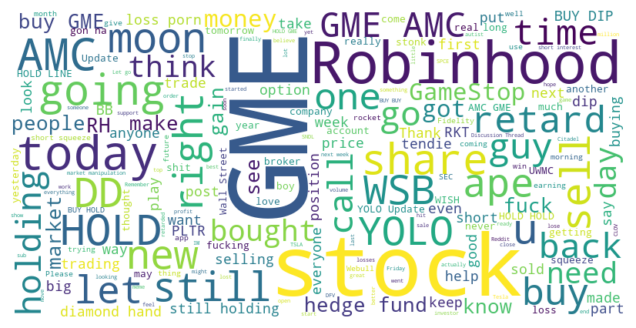

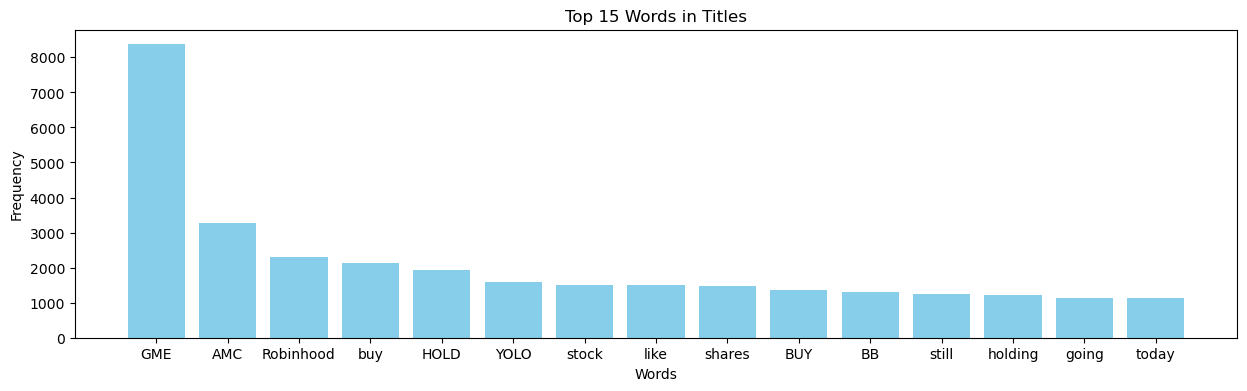

In [32]:
word_cloud(df_explore['title'])

**`Feature body`**
> We are going to repeat here the same exercise that we did for the feature 'title', to chatch the words/stocks that are more frequent

In [33]:
print('\033[1mThere are', df_explore['body'].isnull().sum(), 'nulls in the "body" column')


There are 28449 nulls in the "body" column


In [34]:
# We are going to use only the observations with texts in the 'body' column
df_body = df_explore[df_explore['body'].notnull()]
df_body.head(2)

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn
2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,l6uf6d


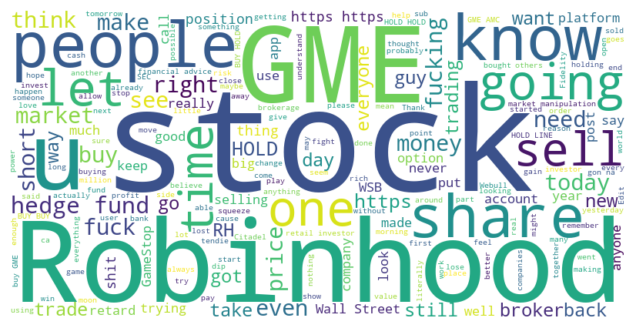

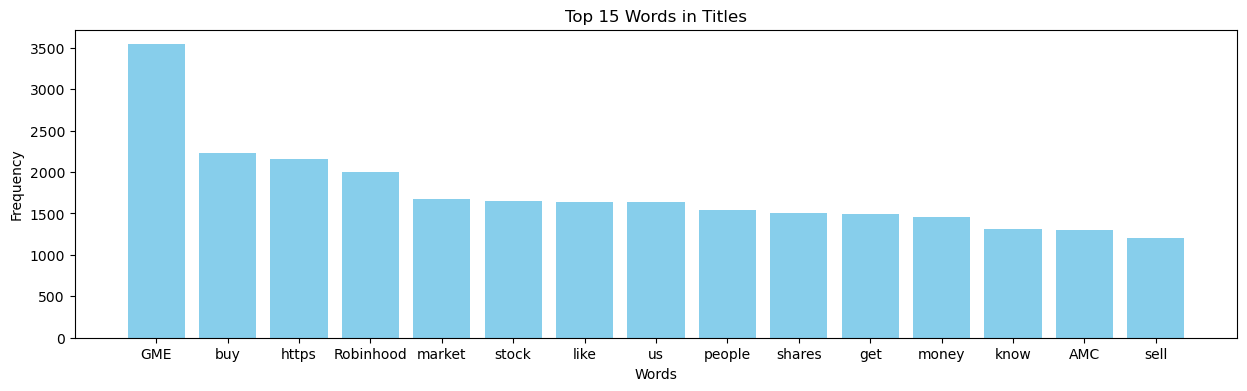

In [35]:
# Visualize in chunks for faster execution
word_cloud(df_body['body'].iloc[0:10000])

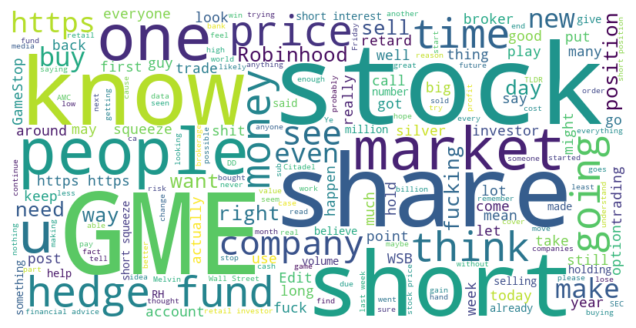

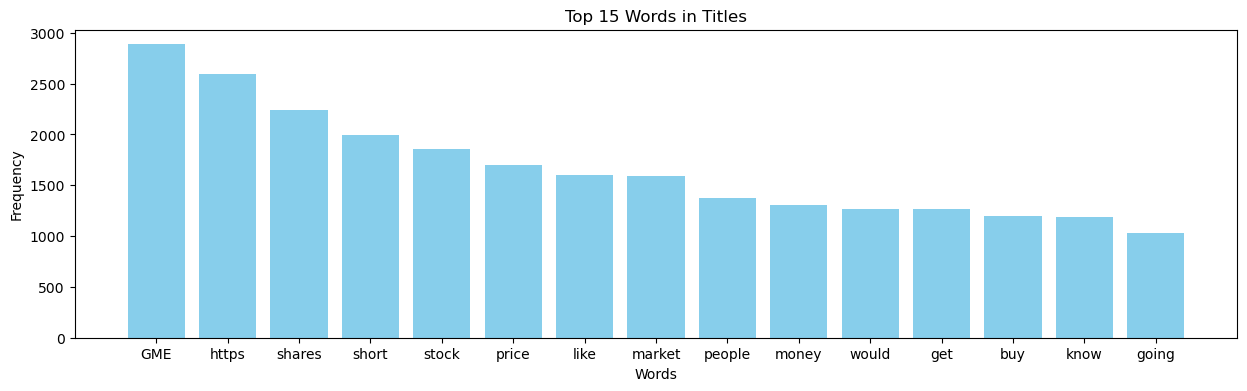

In [36]:
word_cloud(df_body['body'].iloc[10001:12000])

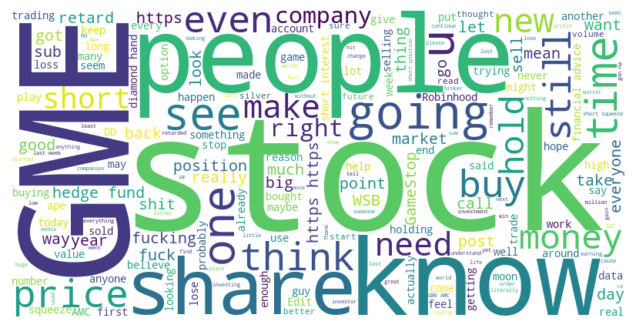

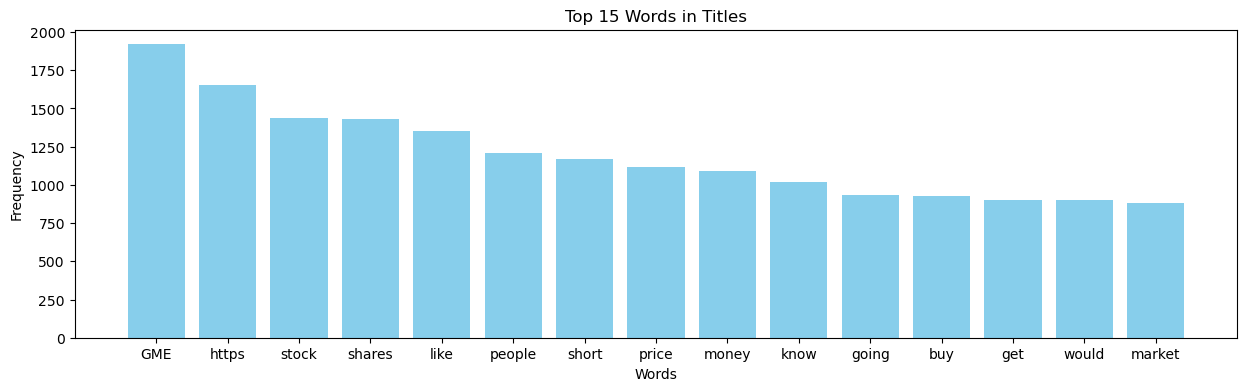

In [37]:
word_cloud(df_body['body'].iloc[12001:15000])

In [38]:
#word_cloud(df_body['body'].iloc[15001:18000])

In [39]:
#word_cloud(df_body['body'].iloc[18001:20000])

In [40]:
#word_cloud(df_body['body'].iloc[20001:25000])

**`Feature Score`**

In [41]:
df_explore['score'].unique()

array([   55,   110,     0, ...,  2997, 45436,  7398], dtype=int64)

In [42]:
# Looking for negative values
df_explore[(df_explore['score'] <0)].sum()

title        0.0
score        0.0
comms_num    0.0
body         0.0
id           0.0
dtype: float64

In [43]:
df_explore['score'].describe()

count     53187.000000
mean       1382.461053
std        7999.271074
min           0.000000
25%           2.000000
50%          37.000000
75%         207.000000
max      348241.000000
Name: score, dtype: float64

In [44]:
# Which one is the post with so a high score
df_explore[df_explore['score']==348241]

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-31 04:00:38,Times Square right now,348241,11554,NaN,l8rf4k


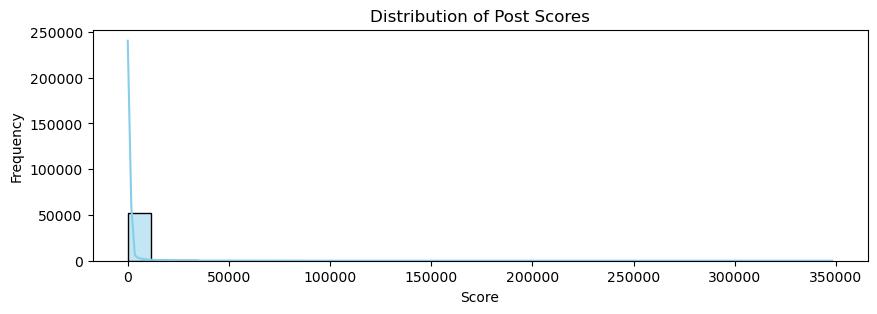

In [45]:
# Distribution plot for 'score'
plt.figure(figsize=(10, 3))
sns.histplot(df_explore['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

> We can see that lower scores are more frequent. Besides that, feature "scores" alone does not give much more information. We will try to find more insights by using the stock symbols that are more frequent in both columns, "title" and "body," and aggregating the data by date.

In [46]:
df_explore['body'] = df_explore['body'].fillna("")

In [47]:
df_explore

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-28 21:37:41,"It's not about the money, it's about sending a...",55,6,,l6ulcx
2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,110,23,,l6uibd
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn
2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,,l6ugk6
2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",71,156,,l6ufgy
...,...,...,...,...,...
2021-08-02 15:03:27,What I Learned Investigating SAVA FUD Spreaders,238,87,***TLDR: Three bitter scientists partnered up ...,owd2pn
2021-08-02 15:01:03,"Daily Popular Tickers Thread for August 02, 20...",228,1070,\nYour daily hype thread. Please keep the shit...,owd1a5
2021-08-02 13:59:35,Hitler reacts to the market being irrational,7398,372,,owc5dr


In [48]:
# Stock symbols that appear more often on the dataset
stocks = ['GME', 'AMC', 'HOOD']

# Columns to search for stock symbols
columns = ['title', 'body']

# New column 'stock_symbol'
df_explore['stock_symbol'] = df_explore[columns].apply(lambda row: next((stock for stock in stocks if any(stock in cell for cell in row)), None), axis=1)
df_explore.head()

,title,score,comms_num,body,id,stock_symbol
timestamp,,,,,,
2021-01-28 21:37:41,"It's not about the money, it's about sending a...",55,6,,l6ulcx,None
2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,110,23,,l6uibd,None
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn,GME
2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,,l6ugk6,GME
2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",71,156,,l6ufgy,GME


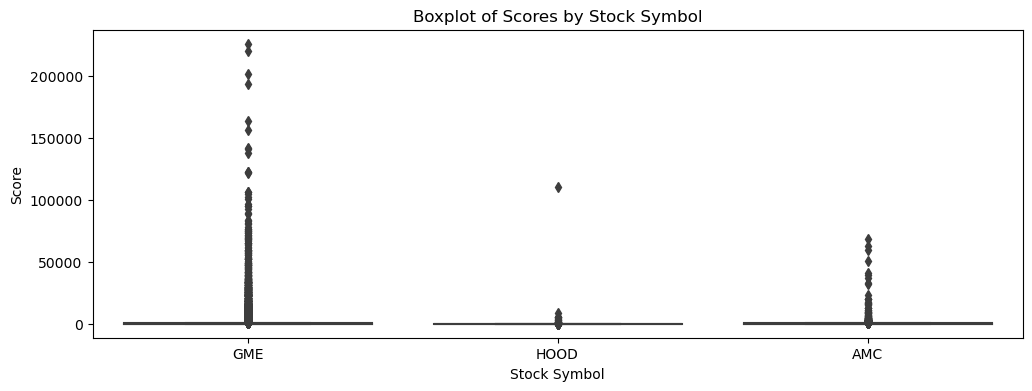

In [49]:
# Plot scores based on stock symbols
plt.figure(figsize=(12, 4))
sns.boxplot(x='stock_symbol', y='score', data=df_explore)
plt.title('Boxplot of Scores by Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Score')
plt.show()

In [50]:
# Convert 'timestamp' (index) to datetime 
df_explore.index = pd.to_datetime(df_explore.index)

# Group by 'date' (extracted from the index) and 'stock_symbol' and calculate the mean score for each group
df_grouped = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['score'].mean().reset_index()
df_grouped.rename(columns = {'level_0':'date'}, inplace = True)
df_grouped.head()

,date,stock_symbol,score
0,2021-01-28,AMC,775.586957
1,2021-01-28,GME,772.871795
2,2021-01-28,HOOD,82.000000
3,2021-01-29,AMC,21.960784
4,2021-01-29,GME,330.421670


In [51]:
# Pivot the DataFrame to have stock symbols as columns
df_pivot = df_grouped.pivot(index='date', columns='stock_symbol', values='score')

In [52]:
df_pivot.head()

stock_symbol,AMC,GME,HOOD
date,,,
2021-01-28,775.586957,772.871795,82.000000
2021-01-29,21.960784,330.421670,81.484241
2021-01-30,935.279070,4630.392578,944.769231
2021-01-31,2320.956522,3088.695431,15981.428571
2021-02-01,4237.310345,3519.669670,684.000000


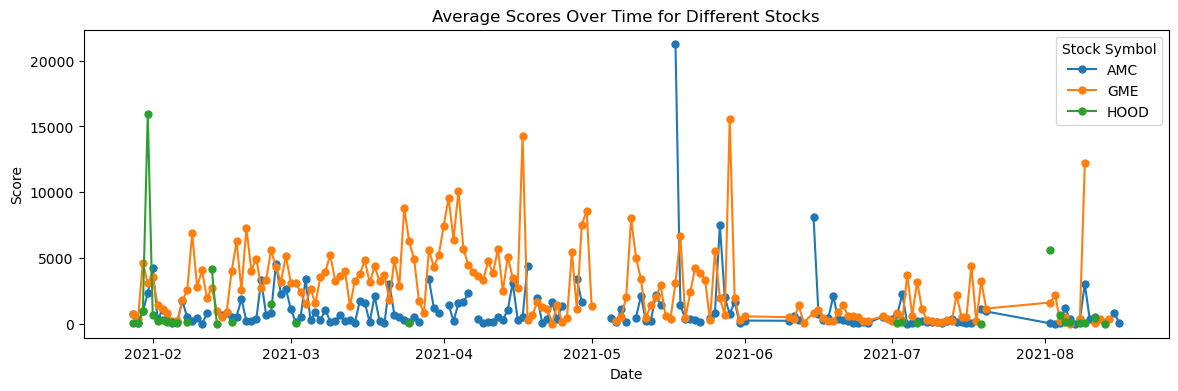

In [53]:
# Line plot for scores over time for each stock
plt.figure(figsize=(14,4 ))
df_pivot.plot(marker='o', markersize=5, ax=plt.gca())
plt.title('Average Scores Over Time for Different Stocks')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(title='Stock Symbol')
plt.show()

**`Feature comms_num`**

In [54]:
df_explore['comms_num'].unique()

array([    6,    23,    47, ..., 13432,  9840, 11688], dtype=int64)

In [55]:
df_explore['comms_num'].describe()

count    53187.000000
mean       263.260252
std       2532.665113
min          0.000000
25%          3.000000
50%         17.000000
75%         60.000000
max      93268.000000
Name: comms_num, dtype: float64

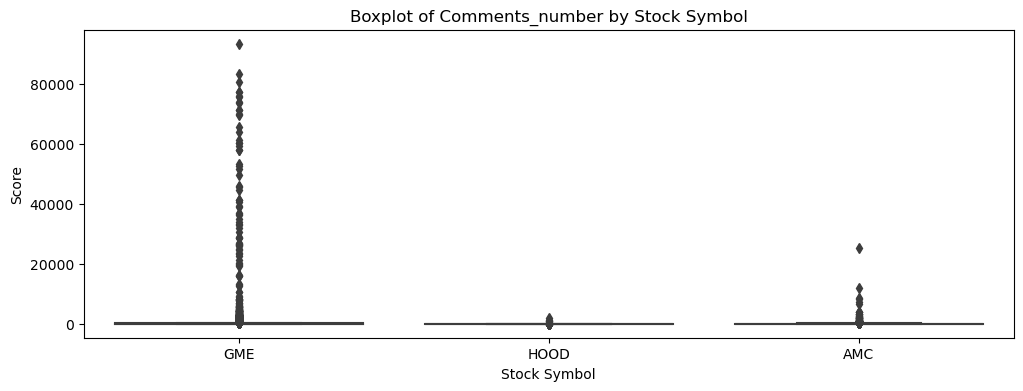

In [56]:
# Plot 'comms_num' based on stock symbols
plt.figure(figsize=(12, 4))
sns.boxplot(x='stock_symbol', y='comms_num', data=df_explore)
plt.title('Boxplot of Comments_number by Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Score')
plt.show()

In [57]:
# Group by 'date' (extracted from the index) and 'stock_symbol' and calculate the mean score for each group
df_grouped_2 = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['score'].mean().reset_index()
df_grouped_2['comms_num'] = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['comms_num'].mean().reset_index()['comms_num']

df_grouped_2.rename(columns = {'level_0':'date'}, inplace = True)
df_grouped_2.head()


,date,stock_symbol,score,comms_num
0,2021-01-28,AMC,775.586957,105.956522
1,2021-01-28,GME,772.871795,88.451282
2,2021-01-28,HOOD,82.000000,10.727273
3,2021-01-29,AMC,21.960784,6.734205
4,2021-01-29,GME,330.421670,67.054628


In [58]:
correlation_coefficient = df_explore['score'].corr(df_explore['comms_num'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.19002684966069866


In [59]:
# Pivot the DataFrame to have stock symbols as columns
df_pivot_2 = df_grouped_2.pivot(index='date', columns='stock_symbol', values=['score', 'comms_num'])

In [60]:
df_pivot_2.head()

score                              comms_num              \
stock_symbol          AMC          GME          HOOD         AMC         GME   
date                                                                           
2021-01-28     775.586957   772.871795     82.000000  105.956522   88.451282   
2021-01-29      21.960784   330.421670     81.484241    6.734205   67.054628   
2021-01-30     935.279070  4630.392578    944.769231  145.860465  674.640625   
2021-01-31    2320.956522  3088.695431  15981.428571  247.304348  318.893401   
2021-02-01    4237.310345  3519.669670    684.000000  300.344828  524.378378   

                          
stock_symbol        HOOD  
date                      
2021-01-28     10.727273  
2021-01-29      8.194842  
2021-01-30     99.000000  
2021-01-31    374.285714  
2021-02-01    152.000000

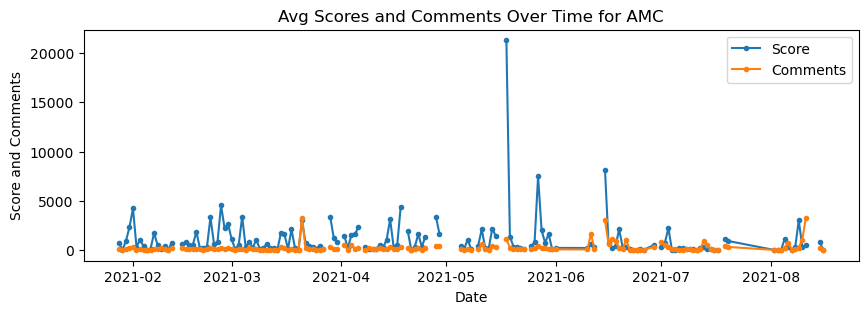

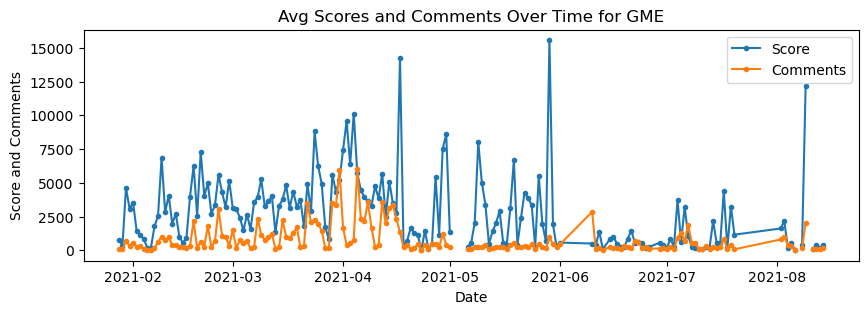

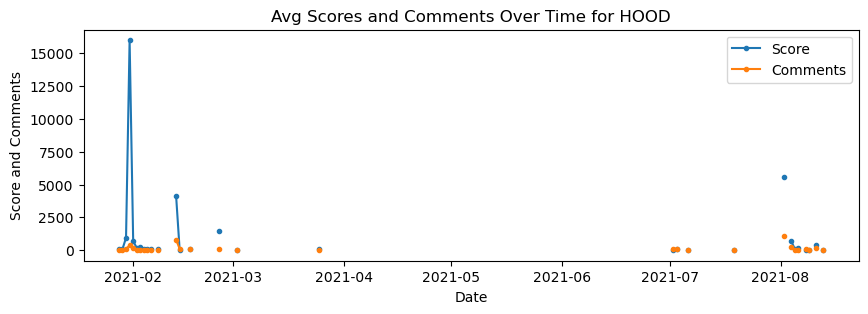

In [61]:
# # Pivot the DataFrame to have stock symbols as columns
# df_pivot_2 = df_grouped_2.pivot(index='date', columns='stock_symbol', values=['score', 'comms_num'])

# List of stock symbols
stock_symbols = df_grouped_2['stock_symbol'].unique()

# Plots for each 'stock_symbol' with both 'score' and 'comms_num' in the same axis
for stock_symbol in stock_symbols:
    plt.figure(figsize=(10, 3))

    # Plot 'score' over time
    plt.plot(df_pivot_2.index, df_pivot_2['score'][stock_symbol], marker='o', markersize=3, label='Score')

    # Plot 'comms_num' over time on the same axis
    plt.plot(df_pivot_2.index, df_pivot_2['comms_num'][stock_symbol], marker='o', markersize=3, label='Comments')

    plt.title(f'Avg Scores and Comments Over Time for {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Score and Comments')
    plt.legend()

    plt.show()    

From the information above:
> - We have to Watch for the outliers for GME and AMC. Maybe they will have to be dropped later on the analysis
> - The correlation coefficient between 'score' and 'comms_num' is 0.19. With the help of the graphs, we can see a high correlation for GME in March and April. For the rest, it does not have any correlation.  



#### Historical data to compare, from yahoo finance 

In [62]:
# Stocks to download
stocks_list = ['AMC', 'GME', 'HOOD']
all_stocks = yf.download(stocks_list, start = ('2021-01-28'), end = ('2021-08-02'))

[*********************100%***********************]  3 of 3 completed


In [63]:
all_stocks.columns

MultiIndex([('Adj Close',  'AMC'),
            ('Adj Close',  'GME'),
            ('Adj Close', 'HOOD'),
            (    'Close',  'AMC'),
            (    'Close',  'GME'),
            (    'Close', 'HOOD'),
            (     'High',  'AMC'),
            (     'High',  'GME'),
            (     'High', 'HOOD'),
            (      'Low',  'AMC'),
            (      'Low',  'GME'),
            (      'Low', 'HOOD'),
            (     'Open',  'AMC'),
            (     'Open',  'GME'),
            (     'Open', 'HOOD'),
            (   'Volume',  'AMC'),
            (   'Volume',  'GME'),
            (   'Volume', 'HOOD')],
           )

In [64]:
all_stocks.head()
# We will take the "Adjusted Close" price to use in our analysis

Adj Close                       Close                  \
                   AMC        GME HOOD         AMC        GME HOOD   
Date                                                                 
2021-01-28   86.300003  48.400002  NaN   86.300003  48.400002  NaN   
2021-01-29  132.600006  81.250000  NaN  132.600006  81.250000  NaN   
2021-02-01  133.000000  56.250000  NaN  133.000000  56.250000  NaN   
2021-02-02   78.199997  22.500000  NaN   78.199997  22.500000  NaN   
2021-02-03   89.699997  23.102501  NaN   89.699997  23.102501  NaN   

                  High                          Low                      Open  \
                   AMC         GME HOOD         AMC      GME HOOD         AMC   
Date                                                                            
2021-01-28  165.000000  120.750000  NaN   65.099998  28.0625  NaN  119.800003   
2021-01-29  160.000000  103.495003  NaN  116.000000  62.5000  NaN  143.100006   
2021-02-01  172.500000   80.500000  NaN  129.100006  53.0000  NaN  170.000000   
2021-02-02  101.000000   39.500000  NaN   60.000000  18.5550  NaN   94.800003   
2021-02-03   97.699997   28.350000  NaN   78.900002  21.3125  NaN   88.500000   

                              Volume                  
                  GME HOOD       AMC        GME HOOD  
Date                                                  
2021-01-28  66.250000  NaN  59122390  235263200  NaN  
2021-01-29  94.927498  NaN  60219330  202264400  NaN  
2021-02-01  79.139999  NaN  43460800  149528800  NaN  
2021-02-02  35.189999  NaN  46277590  312732400  NaN  
2021-02-03  28.002501  NaN  22140510  170794000  NaN

In [65]:
all_stocks_adj = all_stocks[[('Adj Close', 'AMC'), ('Adj Close', 'GME'), ('Adj Close', 'HOOD')]]
all_stocks_adj.head()

Adj Close                
                   AMC        GME HOOD
Date                                  
2021-01-28   86.300003  48.400002  NaN
2021-01-29  132.600006  81.250000  NaN
2021-02-01  133.000000  56.250000  NaN
2021-02-02   78.199997  22.500000  NaN
2021-02-03   89.699997  23.102501  NaN

In [66]:
# Merge the two dataframes based on the date index
df_merged = pd.merge(df_pivot_2, all_stocks_adj, left_index=True, right_index=True)
df_merged.head()

score                            comms_num              \
stock_symbol          AMC          GME        HOOD         AMC         GME   
2021-01-28     775.586957   772.871795   82.000000  105.956522   88.451282   
2021-01-29      21.960784   330.421670   81.484241    6.734205   67.054628   
2021-02-01    4237.310345  3519.669670  684.000000  300.344828  524.378378   
2021-02-02     338.560000  1425.706161  182.500000   64.180000  216.886256   
2021-02-03    1070.677778  1143.230000  255.000000   83.055556  277.930000   

                           Adj Close                  
stock_symbol        HOOD         AMC        GME HOOD  
2021-01-28     10.727273   86.300003  48.400002  NaN  
2021-01-29      8.194842  132.600006  81.250000  NaN  
2021-02-01    152.000000  133.000000  56.250000  NaN  
2021-02-02     27.500000   78.199997  22.500000  NaN  
2021-02-03     35.750000   89.699997  23.102501  NaN

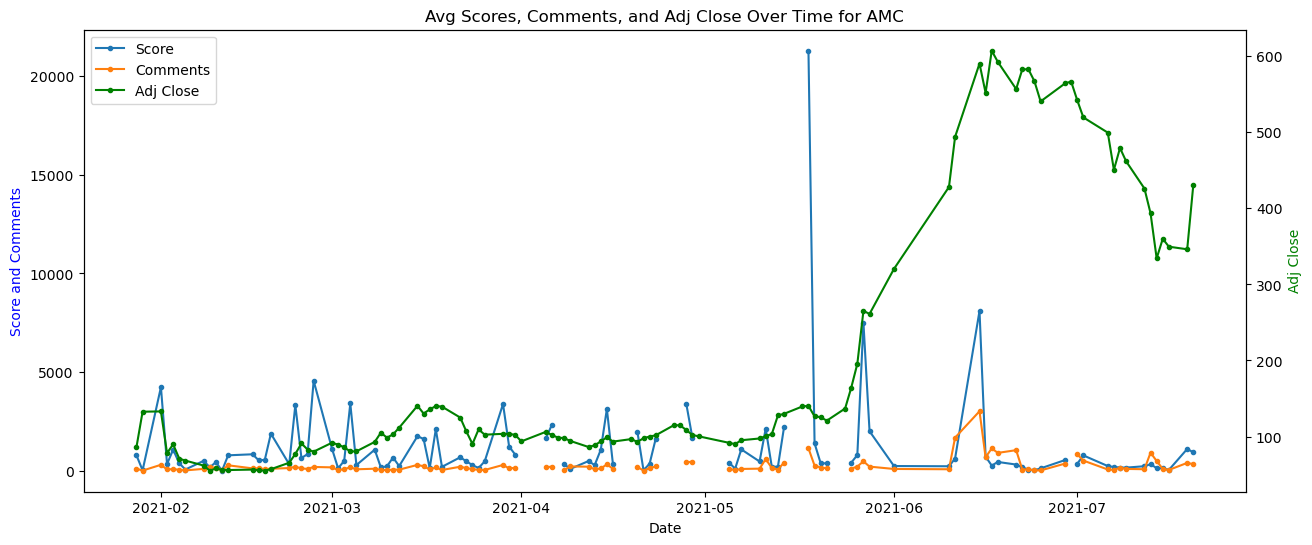

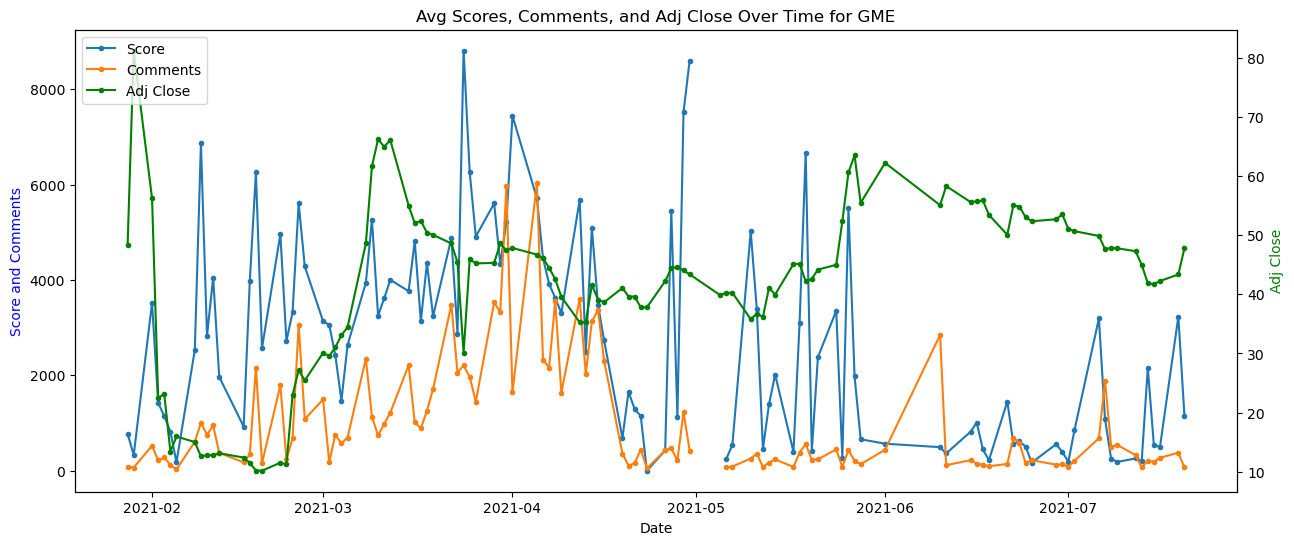

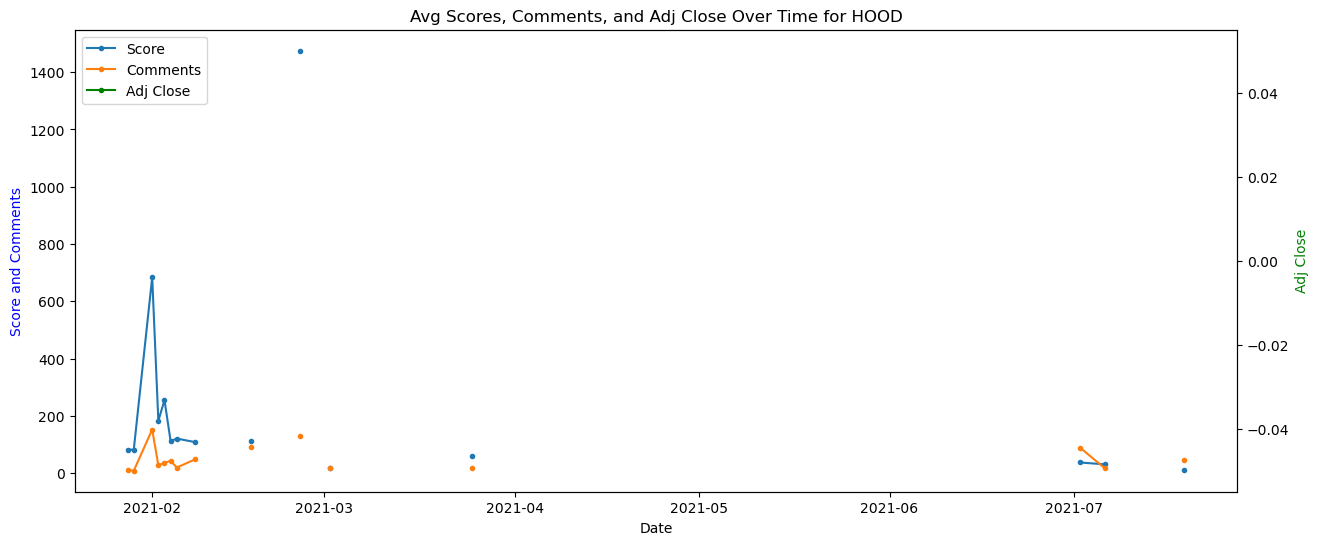

In [67]:
# Plots for each 'stock_symbol' with both 'score' and 'comms_num' in the same axis and Adj Close on a second axis
for stock_symbol in stock_symbols:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot 'score' and 'comms_num' on the primary y-axis
    ax1.plot(df_merged.index, df_merged['score'][stock_symbol], marker='o', markersize=3, label='Score')
    ax1.plot(df_merged.index, df_merged['comms_num'][stock_symbol], marker='o', markersize=3, label='Comments')

    # Create a secondary y-axis
    ax2 = ax1.twinx()

    # Plot 'Adj Close' on the secondary y-axis
    ax2.plot(df_merged.index, df_merged['Adj Close'][stock_symbol], marker='o', markersize=3, label='Adj Close', color='green')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score and Comments', color='blue')
    ax2.set_ylabel('Adj Close', color='green')
    plt.title(f'Avg Scores, Comments, and Adj Close Over Time for {stock_symbol}')

    # Show legend for both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()


> Just visualizing the historical data of stock prices of AMC and GME versus the score and number of comments on Reddit, it does not seem that these two have a real effect on stock prices

## 3. Model

In [195]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from textblob import TextBlob


# Download stock data, for the time period of the reddit posts
amc = yf.download('AMC', start='2020-09-29', end='2021-08-16')
gme = yf.download('GME', start='2020-09-29', end='2021-08-16')

# Create lag features for closing prices
amc['AMC_Close_Lag1'] = amc['Close'].shift(1)
gme['GME_Close_Lag1'] = gme['Close'].shift(1)

# Create rolling mean and st. dev features
amc['AMC_Close_RollingMean'] = amc['Close'].rolling(window=5).mean()
amc['AMC_Close_RollingStd'] = amc['Close'].rolling(window=5).std()

gme['GME_Close_RollingMean'] = gme['Close'].rolling(window=5).mean()
gme['GME_Close_RollingStd'] = gme['Close'].rolling(window=5).std()

# Merge data
merged_data = pd.merge(amc, gme, left_index=True, right_index=True, how='inner', suffixes=('_AMC', '_GME'))

# Create features and target variables
features_amc = [
    'Open_AMC', 'High_AMC', 'Low_AMC', 'Volume_AMC', 'AMC_Close_Lag1',
    'AMC_Close_RollingMean', 'AMC_Close_RollingStd'
]
target_amc = 'Close_AMC'

features_gme = [
    'Open_GME', 'High_GME', 'Low_GME', 'Volume_GME', 'GME_Close_Lag1',
    'GME_Close_RollingMean', 'GME_Close_RollingStd'
]
target_gme = 'Close_GME'

X_amc = merged_data[features_amc]
y_amc = merged_data[target_amc]

X_gme = merged_data[features_gme]
y_gme = merged_data[target_gme]

# Split the data into training and testing sets
X_amc_train, X_amc_test, y_amc_train, y_amc_test = train_test_split(X_amc, y_amc, test_size=0.2, random_state=42)
X_gme_train, X_gme_test, y_gme_train, y_gme_test = train_test_split(X_gme, y_gme, test_size=0.2, random_state=42)

# Replace missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_amc_train_imputed = imputer.fit_transform(X_amc_train)
X_amc_test_imputed = imputer.transform(X_amc_test)

X_gme_train_imputed = imputer.fit_transform(X_gme_train)
X_gme_test_imputed = imputer.transform(X_gme_test)

# Feature scaling
scaler = StandardScaler()
X_amc_train_scaled = scaler.fit_transform(X_amc_train_imputed)
X_amc_test_scaled = scaler.transform(X_amc_test_imputed)

X_gme_train_scaled = scaler.fit_transform(X_gme_train_imputed)
X_gme_test_scaled = scaler.transform(X_gme_test_imputed)

# Train the model using RandomForestRegressor
model_amc = RandomForestRegressor(n_estimators=100, random_state=42)
model_gme = RandomForestRegressor(n_estimators=100, random_state=42)

model_amc.fit(X_amc_train_scaled, y_amc_train)
model_gme.fit(X_gme_train_scaled, y_gme_train)

# Make predictions
y_amc_pred_scaled = model_amc.predict(X_amc_test_scaled)
y_gme_pred_scaled = model_gme.predict(X_gme_test_scaled)

# Evaluate the model
mse_amc_scaled = mean_squared_error(y_amc_test, y_amc_pred_scaled)
mse_gme_scaled = mean_squared_error(y_gme_test, y_gme_pred_scaled)

mae_amc_scaled = mean_absolute_error(y_amc_test, y_amc_pred_scaled)
mae_gme_scaled = mean_absolute_error(y_gme_test, y_gme_pred_scaled)

r2_amc_scaled = r2_score(y_amc_test, y_amc_pred_scaled)
r2_gme_scaled = r2_score(y_gme_test, y_gme_pred_scaled)


# Print results
print(f"R-squared for AMC: {r2_amc_scaled}")
print(f"R-squared for GME: {r2_gme_scaled}")

print(f"Mean Absolute Error for AMC: {mae_amc_scaled}")
print(f"Mean Absolute Error for GME: {mae_gme_scaled}")

print(f"Mean Squared Error for AMC: {mse_amc_scaled}")
print(f"Mean Squared Error for GME: {mse_gme_scaled}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
R-squared for AMC: 0.9935313943768258
R-squared for GME: 0.9669608899658846
Mean Absolute Error for AMC: 7.5271325522528745
Mean Absolute Error for GME: 1.9184724563492668
Mean Squared Error for AMC: 204.54097835119876
Mean Squared Error for GME: 15.856735280509287


In [196]:
# Get sentiment from reddit text
def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Add sentiment column
df['sentiment'] = df['body'].apply(get_sentiment)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Adjust reddit timestamps
df['timestamp'] = df['timestamp'].dt.floor('d')

# Get stock prices
amc_data = yf.download('AMC', start='2020-09-29', end='2021-08-16')
gme_data = yf.download('GME', start='2020-09-29', end='2021-08-16')


# Choose columns
amc_data = amc_data[['Open', 'High', 'Low', 'Volume', 'Close']]
gme_data = gme_data[['Open', 'High', 'Low', 'Volume', 'Close']]

# Rename columns
amc_data.columns = [f'AMC_{col}' for col in amc_data.columns]
gme_data.columns = [f'GME_{col}' for col in gme_data.columns]

# Merge data
stock_data = pd.concat([amc_data, gme_data], axis=1)

# Drop NA's
stock_data = stock_data.dropna()

# Set close prices as target varible
features = ['AMC_Open', 'AMC_High', 'AMC_Low', 'AMC_Volume', 'GME_Open', 'GME_High', 'GME_Low', 'GME_Volume']

# Merge stock and Reddit data
merged_data = pd.merge(df, stock_data, left_on='timestamp', right_index=True, how='left')

# Check merged dataset
print(merged_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                               title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.red

In [197]:
# Assume sentiment, AMC_Close, and GME_Close are relevant features
features = ['sentiment', 'AMC_Open', 'AMC_High', 'AMC_Low', 'AMC_Volume', 'GME_Open', 'GME_High', 'GME_Low', 'GME_Volume']
target_amc = 'AMC_Close'
target_gme = 'GME_Close'

# Create feature matrix
X = merged_data[features]
y_amc = merged_data[target_amc]
y_gme = merged_data[target_gme]

# Combine X and y for easier data cleaning
combined_data = pd.concat([X, y_amc, y_gme], axis=1)

# Drop rows with NaN or infinity in the target variable for AMC and GME
combined_data = combined_data[~y_amc.isna() & ~y_amc.isin([np.inf, -np.inf]) & ~y_gme.isna() & ~y_gme.isin([np.inf, -np.inf])]

# Separate
X = combined_data[features]
y_amc = combined_data[target_amc]
y_gme = combined_data[target_gme]

# Split the data into training and testing sets
X_train_amc, X_test_amc, y_train_amc, y_test_amc = train_test_split(X, y_amc, test_size=0.2, random_state=42)
X_train_gme, X_test_gme, y_train_gme, y_test_gme = train_test_split(X, y_gme, test_size=0.2, random_state=42)

# Replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

X_train_imputed_amc = imputer.fit_transform(X_train_amc)
X_test_imputed_amc = imputer.transform(X_test_amc)

X_train_imputed_gme = imputer.fit_transform(X_train_gme)
X_test_imputed_gme = imputer.transform(X_test_gme)

# Train RFR model for AMC
model_amc = RandomForestRegressor(n_estimators=100, random_state=42)
model_amc.fit(X_train_imputed_amc, y_train_amc)

# Make predictions on the test set for AMC
y_pred_amc = model_amc.predict(X_test_imputed_amc)

# Evaluate the model for AMC
mse_amc = mean_squared_error(y_test_amc, y_pred_amc)
print(f'Mean Squared Error for AMC: {mse_amc}')

# Train RFR model for GME
model_gme = RandomForestRegressor(n_estimators=100, random_state=42)
model_gme.fit(X_train_imputed_gme, y_train_gme)

# Make predictions on the test set for GME
y_pred_gme = model_gme.predict(X_test_imputed_gme)

# Evaluate the model for GME
mse_gme = mean_squared_error(y_test_gme, y_pred_gme)
print(f'Mean Squared Error for GME: {mse_gme}')


Mean Squared Error for AMC: 0.0
Mean Squared Error for GME: 0.0


In [198]:
# Print feature importances
feature_importances_amc = pd.Series(model_amc.feature_importances_, index=features)
feature_importances_gme = pd.Series(model_gme.feature_importances_, index=features)

print("Feature importances for AMC:")
print(feature_importances_amc)

print("\nFeature importances for GME:")
print(feature_importances_gme)


Feature importances for AMC:
sentiment     1.301017e-15
AMC_Open      5.138475e-03
AMC_High      1.223323e-02
AMC_Low       9.745242e-01
AMC_Volume    1.246338e-03
GME_Open      1.400175e-03
GME_High      3.060276e-04
GME_Low       4.812220e-03
GME_Volume    3.393067e-04
dtype: float64

Feature importances for GME:
sentiment     7.431809e-16
AMC_Open      3.253355e-03
AMC_High      1.314900e-02
AMC_Low       2.320846e-04
AMC_Volume    1.364258e-04
GME_Open      8.977627e-01
GME_High      7.572796e-03
GME_Low       7.735899e-02
GME_Volume    5.346977e-04
dtype: float64


In [199]:
# MSE on training data
mse_train_amc = mean_squared_error(y_train_amc, model_amc.predict(X_train_imputed_amc))
mse_train_gme = mean_squared_error(y_train_gme, model_gme.predict(X_train_imputed_gme))

# Print MSE
print(f'Mean Squared Error for AMC on Training Data: {mse_train_amc}')
print(f'Mean Squared Error for GME on Training Data: {mse_train_gme}')


Mean Squared Error for AMC on Training Data: 0.00018975811932925505
Mean Squared Error for GME on Training Data: 0.00029926741917501645


In [200]:
# MSE on test data
mse_test_amc = mean_squared_error(y_test_amc, model_amc.predict(X_test_imputed_amc))
mse_test_gme = mean_squared_error(y_test_gme, model_gme.predict(X_test_imputed_gme))

# Print MSE
print(f'Mean Squared Error for AMC on Test Data: {mse_test_amc}')
print(f'Mean Squared Error for GME on Test Data: {mse_test_gme}')


Mean Squared Error for AMC on Test Data: 0.0
Mean Squared Error for GME on Test Data: 0.0


In [201]:
# CrossVal Score
cv_scores_amc = cross_val_score(model_amc, X, y_amc, cv=5, scoring='neg_mean_squared_error')
cv_scores_gme = cross_val_score(model_gme, X, y_gme, cv=5, scoring='neg_mean_squared_error')

# Print CrossVal score
print(f'Cross-val MSE scores for AMC: {cv_scores_amc}')
print(f'Cross-val MSE scores for GME: {cv_scores_gme}')


Cross-val MSE scores for AMC: [-6.27435180e+00 -0.00000000e+00 -2.85694438e+01 -1.39578767e+02
 -5.79361741e+04]
Cross-val MSE scores for GME: [-64.46641774  -0.         -38.97130052 -53.75201827 -66.89629146]


In [202]:
# CrossVal Score w/ Time Series Split

cv_scores_amc = cross_val_score(model_amc, X, y_amc, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
cv_scores_gme = cross_val_score(model_gme, X, y_gme, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')

# Get positive MSE
cv_scores_amc = -cv_scores_amc
cv_scores_gme = -cv_scores_gme

# Print CrossVal w/ time-series score
print(f'Cross-val MSE scores for AMC (time series): {cv_scores_amc}')
print(f'Cross-val MSE scores for GME (time series): {cv_scores_gme}')


Cross-val MSE scores for AMC (time series): [    0.           154.54669821   272.28569859   383.09052215
 69124.13331205]
Cross-val MSE scores for GME (time series): [  0.         665.07013444  76.45537431 150.73916471  12.21184337]
